# AH2179 Applied Artificial Intelligence in Transportation Group 5 Project
### By Fabian Fermazin, William Öman, Itsuki Shindo

In [9]:
#pip install calmap

In [10]:
import pandas as pd
import numpy as np; np.random.seed(sum(map(ord, 'calmap')))
import calmap
import matplotlib.pyplot as plt
from datetime import datetime

In [11]:
df = pd.read_csv('Dataset-PT_seasons.csv')
Stockholmtemp2022 = pd.read_csv('Stockholmtemp2022.csv', sep=';')

In [12]:
# Change the date format of Stockholmtemp2022 to match the df
def change_date_format(date_str):
    date_obj = pd.to_datetime(date_str)
    return date_obj.strftime("%Y%m%d")
Stockholmtemp2022["date"] = Stockholmtemp2022["date"].apply(change_date_format)

# Change the name of the date column to match the df
Stockholmtemp2022["Calendar_date"] = 0
Stockholmtemp2022["Calendar_date"] = Stockholmtemp2022["date"]
Stockholmtemp2022.drop(columns=["date"])

,temp,Calendar_date
0,-1.4,20220101
1,1.9,20220102
2,3.6,20220103
3,0.6,20220104
4,-2.2,20220105
...,...,...
176,23.1,20220626
177,24.1,20220627
178,24.1,20220628
179,19.6,20220629


In [13]:
# Merge df and Stockholmtemp2022
Stockholmtemp2022["Calendar_date"] = Stockholmtemp2022["Calendar_date"].astype(int)
df = pd.merge(df, Stockholmtemp2022, on='Calendar_date')
df.drop(columns=['date'])
df["Calendar_date"] = pd.to_datetime(df['Calendar_date'], format='%Y%m%d')

In [14]:
days = np.unique(df[['Calendar_date']].values.ravel())

Calendar_date
2022-05-20    3969
2022-04-06    3969
2022-02-17    3969
2022-05-16    3969
2022-01-18    3969
              ... 
2022-05-30     108
2022-05-31      81
2022-06-01      81
2022-06-02      81
2022-06-03      81
Length: 173, dtype: int64

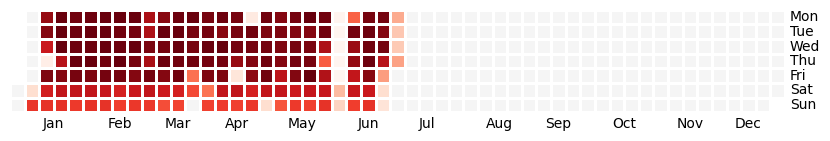

In [15]:
#higher frequency = more buses (or data measurements) that day
df['Calendar_date'] = pd.to_datetime(df['Calendar_date'])
date_freq = df.value_counts('Calendar_date')
plt.figure(figsize=(10,5))
calmap.yearplot(date_freq, year = 2022)
date_freq


Calendar_date
2022-05-20    3969
2022-04-06    3969
2022-02-17    3969
2022-05-16    3969
2022-01-18    3969
              ... 
2022-05-30     108
2022-05-31      81
2022-06-01      81
2022-06-02      81
2022-06-03      81
Length: 173, dtype: int64

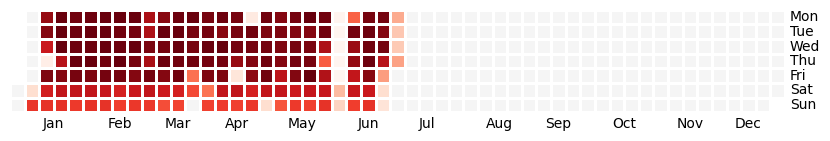

In [16]:
#higher frequency = more buses (or data measurements) that day
df['Calendar_date'] = pd.to_datetime(df['Calendar_date'])
date_freq = df.value_counts('Calendar_date')
plt.figure(figsize=(10,5))
calmap.yearplot(date_freq, year = 2022)
date_freq

In [22]:
snow_by_day = df.groupby(df['Calendar_date'].dt.date)['factor(weather)Snow'].sum() > 0
days_with_snow = snow_by_day[snow_by_day].index
print("Days with snow:")
for day in days_with_snow:
    print(day)

Days with snow:
2022-02-08
2022-02-19
2022-02-21
2022-03-29
2022-04-01
2022-04-05
2022-04-07
2022-04-08
2022-04-09


In [24]:
lightsnow_by_day = df.groupby(df['Calendar_date'].dt.date)['factor(weather)Light_Snow'].sum() > 0
days_with_lightsnow = lightsnow_by_day[lightsnow_by_day].index
print("Days with light snow:")
for day in days_with_lightsnow:
    print(day)

Days with light snow:
2022-01-08
2022-01-17
2022-01-29
2022-01-30
2022-02-01
2022-02-02
2022-02-08
2022-02-17
2022-02-19
2022-02-21
2022-02-23
2022-03-31
2022-04-01
2022-04-04
2022-04-07
2022-04-08
2022-04-09


In [26]:
rain_by_day = df.groupby(df['Calendar_date'].dt.date)['factor(weather)Rain'].sum() > 0
days_with_rain = rain_by_day[rain_by_day].index
print("Days with rain:")
for day in days_with_rain:
    print(day)

Days with rain:
2022-01-29
2022-02-16
2022-04-07
2022-05-07
2022-05-11
2022-05-14
2022-05-20
2022-05-27
2022-05-28


In [25]:
#weather_data = df.set_index('Calendar_date')['factor(weather)Snow']
plt.figure(figsize=(10,5))
calmap.yearplot(days_with_snow, year=2022, cmap='winter')

TypeError: ignored

<Figure size 1000x500 with 0 Axes>